In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime


#### The purpose of this project is to detect credit card fraud.  I will be using a dataset that contains information on European credit card transactions from September 2013.  It accounts for a total of 284,807 transactions over two days, containing 492 fraud transactions.  The dataset has 31 total columns of which columns V1-V28 are the principle components obtained using PCA.  The only original columns in our dataset are the "Time" and "Amount" columns.

In [2]:
df = pd.read_csv('credit card fraud.csv')
df = df.drop_duplicates()
print(df.head())
print(df.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

In [3]:
# Resampling our data

# Class count
count_class_0, count_class_1 = df.Class.value_counts()
print(count_class_0)
print(count_class_1)
# Divide by class
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

283253
473


Random under-sampling:
1    473
0    473
Name: Class, dtype: int64


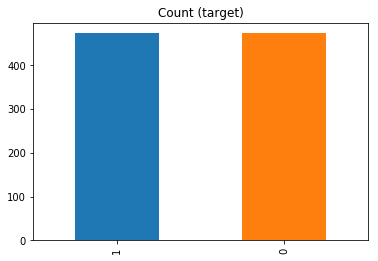

In [4]:
#extract the observations with class zero, equal to the number of obervations equal
df_class_0_under = df_class_0.sample(count_class_1)

#create a new dataframe with the same number of values for our two classes
new_df = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(new_df.Class.value_counts())

new_df.Class.value_counts().plot(kind='bar', title='Count (target)')

In [5]:
#split the data
X = new_df.drop('Class', 1)
Y = new_df['Class']
print(X.shape)
print(Y.shape)

(946, 30)
(946,)


AxesSubplot(0.125,0.125;0.62x0.755)


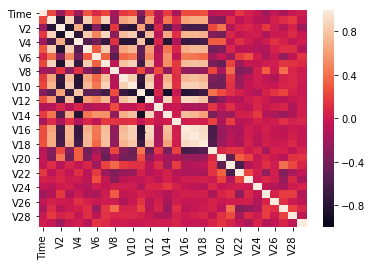

In [6]:
#Creating a heatmap to check for any correlation between our independent variables, or in this case the vectors from PCA.
Xvar_heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1)

print(Xvar_heatmap)


#X_grid = sns.PairGrid(X)
#X_grid = X_grid.map(plt.scatter)

In [7]:
#splitting the data into train and test groups.

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=.3, random_state=20)
print(test_X.shape)
print(test_Y.shape)

(284, 30)
(284,)


## Naive Bayes Model:

In [8]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

#set start time
start_time = datetime.datetime.now()

# Fit our model to the data.
bnb.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_bayes = bnb.predict(test_X)

#Run accuracy score
print('Accuracy score: ' + str(metrics.accuracy_score(test_Y, y_pred_bayes)))

#calculate end time
end_time = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time - start_time))
print()

#Use cross validation to gauge the accuracy of our model
Nbayes_cvs = cross_val_score(bnb, X, Y, cv=10, scoring='accuracy')
print(Nbayes_cvs)
print('Average cross validated score from our Naive Bayes model is: ' + str(np.mean(Nbayes_cvs)))



Accuracy score: 0.897887323943662

Duration: 0:00:00.055036

[0.9375     0.9375     0.95833333 0.87234043 0.88297872 0.82978723
 0.96808511 0.87234043 0.88297872 0.86170213]
Average cross validated score from our Naive Bayes model is: 0.900354609929078


AUC Score: 0.947


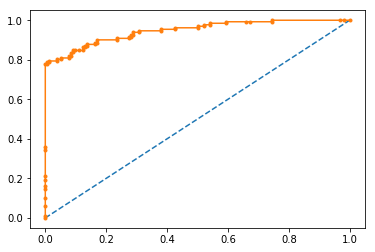

In [9]:
# predict probabilities
probs = bnb.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
bayes_auc = roc_auc_score(test_Y, probs)
print('AUC Score: %.3f' % bayes_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_Y, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [10]:
#perform classification report of naive bayes model
class_names = ['Class_0', 'Class_1']
tree_report = classification_report(test_Y, y_pred_bayes, target_names=class_names)
print(tree_report)

              precision    recall  f1-score   support

     Class_0       0.84      0.99      0.91       153
     Class_1       0.98      0.78      0.87       131

   micro avg       0.89      0.89      0.89       284
   macro avg       0.91      0.88      0.89       284
weighted avg       0.90      0.89      0.89       284



#### Confusion Matrix:

In [11]:
confusion_matrix(test_Y, y_pred_bayes)

array([[151,   2],
       [ 29, 102]], dtype=int64)

## Decision Tree Model:

In [12]:
# perform grid search to find the optimal parameters for our decision tree model.
dtree = tree.DecisionTreeClassifier(random_state=2)
tree_param_grid = {'max_depth':[2,4,6], 'min_samples_split':[2,5,8], 'max_features':[2,4,6]}
dtree_grid = GridSearchCV(dtree, tree_param_grid, cv=5, verbose=3)
dtree_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=2, max_features=2, min_samples_split=2 ................
[CV]  max_depth=2, max_features=2, min_samples_split=2, score=0.9323308270676691, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2 ................
[CV]  max_depth=2, max_features=2, min_samples_split=2, score=0.9172932330827067, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2 ................
[CV]  max_depth=2, max_features=2, min_samples_split=2, score=0.8863636363636364, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2 ................
[CV]  max_depth=2, max_features=2, min_samples_split=2, score=0.8712121212121212, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2 ................
[CV]  max_depth=2, max_features=2, min_samples_split=2, score=0.8863636363636364, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=5 ................
[CV]  max_depth=2, max_features=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=2, max_features=4, min_samples_split=5 ................
[CV]  max_depth=2, max_features=4, min_samples_split=5, score=0.9323308270676691, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=5 ................
[CV]  max_depth=2, max_features=4, min_samples_split=5, score=0.8721804511278195, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=5 ................
[CV]  max_depth=2, max_features=4, min_samples_split=5, score=0.8939393939393939, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=5 ................
[CV]  max_depth=2, max_features=4, min_samples_split=5, score=0.8484848484848485, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=5 ................
[CV]  max_depth=2, max_features=4, min_samples_split=5, score=0.8484848484848485, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=8 ................
[CV]  max_depth=2, max_features=4, min_samples_split=8, score=0.9323308270676691, total=   0.

[CV]  max_depth=4, max_features=4, min_samples_split=8, score=0.8939393939393939, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=8 ................
[CV]  max_depth=4, max_features=4, min_samples_split=8, score=0.8560606060606061, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=8 ................
[CV]  max_depth=4, max_features=4, min_samples_split=8, score=0.8484848484848485, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=2 ................
[CV]  max_depth=4, max_features=6, min_samples_split=2, score=0.9097744360902256, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=2 ................
[CV]  max_depth=4, max_features=6, min_samples_split=2, score=0.9022556390977443, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=2 ................
[CV]  max_depth=4, max_features=6, min_samples_split=2, score=0.9166666666666666, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=2 ...............

[CV]  max_depth=6, max_features=6, min_samples_split=5, score=0.8947368421052632, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=5 ................
[CV]  max_depth=6, max_features=6, min_samples_split=5, score=0.9015151515151515, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=5 ................
[CV]  max_depth=6, max_features=6, min_samples_split=5, score=0.8787878787878788, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=5 ................
[CV]  max_depth=6, max_features=6, min_samples_split=5, score=0.9015151515151515, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=8 ................
[CV]  max_depth=6, max_features=6, min_samples_split=8, score=0.9022556390977443, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=8 ................
[CV]  max_depth=6, max_features=6, min_samples_split=8, score=0.8947368421052632, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=8 ...............

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    1.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 8], 'max_features': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [13]:
print('Best parameters for decision tree:', dtree_grid.best_params_)

Best parameters for decision tree: {'max_depth': 6, 'max_features': 6, 'min_samples_split': 8}


In [12]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=6,
    min_samples_split=8,
    random_state = 6
)

#set start time
start_time2 = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_dtree)))

#calculate end time
end_time2 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time2 - start_time2))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, X, Y, cv=5, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Accuracy score for decision tree Model: 0.8943661971830986

Duration: 0:00:00.010007

[0.94210526 0.91578947 0.82631579 0.93085106 0.79787234]
Average cross validated score from our decision tree model is: 0.8825867861142218


AUC Score: 0.906


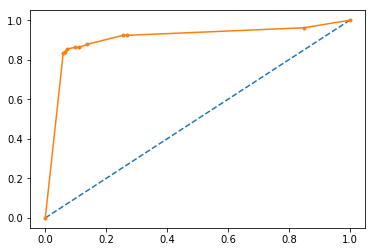

In [13]:
# predict probabilities
probs_dtree = decision_tree.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_dtree = probs_dtree[:, 1]
# calculate AUC
dtree_auc = roc_auc_score(test_Y, probs_dtree)
print('AUC Score: %.3f' % dtree_auc)
# calculate roc curve
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(test_Y, probs_dtree)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dtree, tpr_dtree, marker='.')
# show the plot
plt.show()

In [16]:
# perform classification report of the decision tree
class_names = ['Class_0', 'Class_1']
tree_report = classification_report(test_Y, y_pred_dtree, target_names=class_names)
print(tree_report)

              precision    recall  f1-score   support

     Class_0       0.77      1.00      0.87       153
     Class_1       1.00      0.66      0.79       131

   micro avg       0.84      0.84      0.84       284
   macro avg       0.89      0.83      0.83       284
weighted avg       0.88      0.84      0.84       284



In [17]:
#create confusion matrix
confusion_matrix(test_Y, y_pred_dtree)

array([[153,   0],
       [ 45,  86]], dtype=int64)

## Random Forest Model:

In [18]:
# perform grid search to find the optimal parameters for our random forest model.
rforest = ensemble.RandomForestClassifier(random_state=8)
forest_param_grid = {'n_estimators':[10,20,100], 'max_depth':[2,4,6], 'min_samples_split':[2,5,8], 
                     'max_features':[2,4,6]}
rforest_grid = GridSearchCV(rforest, forest_param_grid, cv=5, verbose=3)
rforest_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, score=0.9548872180451128, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, score=0.924812030075188, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, score=0.9166666666666666, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, score=0.8484848484848485, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=10, score=0.9166666666666666, total=   0.0s
[CV] max_depth

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=20, score=0.9473684210526315, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=20, score=0.9097744360902256, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=20, score=0.9318181818181818, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=20, score=0.8484848484848485, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=20, score=0.9166666666666666, total=   0.0s
[CV] max_depth=2, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=2, min_samples_split=2, n_estimators=100, 

[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=4, min_samples_split=2, n_estimators=20, score=0.9318181818181818, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=4, min_samples_split=2, n_estimators=20, score=0.8863636363636364, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=4, min_samples_split=2, n_estimators=20, score=0.9166666666666666, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=4, min_samples_split=2, n_estimators=100, score=0.9548872180451128, total=   0.1s
[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=4, min_samples_split=2, n_estimators=100, score=0.924812030075188, total=   0.0s
[CV] max_depth=2, max_features=4, min_samples_split=2, n_estimators=100 

[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimators=20, score=0.9166666666666666, total=   0.0s
[CV] max_depth=2, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimators=100, score=0.9548872180451128, total=   0.1s
[CV] max_depth=2, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimators=100, score=0.9323308270676691, total=   0.1s
[CV] max_depth=2, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimators=100, score=0.9318181818181818, total=   0.0s
[CV] max_depth=2, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimators=100, score=0.9090909090909091, total=   0.1s
[CV] max_depth=2, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=6, min_samples_split=2, n_estimato

[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimators=20, score=0.9166666666666666, total=   0.0s
[CV] max_depth=4, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimators=100, score=0.9548872180451128, total=   0.1s
[CV] max_depth=4, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimators=100, score=0.924812030075188, total=   0.1s
[CV] max_depth=4, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimators=100, score=0.9318181818181818, total=   0.1s
[CV] max_depth=4, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimators=100, score=0.8939393939393939, total=   0.1s
[CV] max_depth=4, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=2, min_samples_split=2, n_estimator

[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimators=20, score=0.9318181818181818, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimators=100, score=0.9624060150375939, total=   0.1s
[CV] max_depth=4, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimators=100, score=0.924812030075188, total=   0.1s
[CV] max_depth=4, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimators=100, score=0.9318181818181818, total=   0.0s
[CV] max_depth=4, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimators=100, score=0.9090909090909091, total=   0.1s
[CV] max_depth=4, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=4, min_samples_split=2, n_estimator

[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimators=20, score=0.9090909090909091, total=   0.0s
[CV] max_depth=4, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimators=100, score=0.9699248120300752, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimators=100, score=0.924812030075188, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimators=100, score=0.9242424242424242, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimators=100, score=0.9090909090909091, total=   0.1s
[CV] max_depth=4, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=4, max_features=6, min_samples_split=2, n_estimator

[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimators=20, score=0.9242424242424242, total=   0.0s
[CV] max_depth=6, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimators=100, score=0.9624060150375939, total=   0.1s
[CV] max_depth=6, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimators=100, score=0.9398496240601504, total=   0.0s
[CV] max_depth=6, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimators=100, score=0.9242424242424242, total=   0.0s
[CV] max_depth=6, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimators=100, score=0.8939393939393939, total=   0.0s
[CV] max_depth=6, max_features=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=2, min_samples_split=2, n_estimato

[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimators=20, score=0.9318181818181818, total=   0.0s
[CV] max_depth=6, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimators=100, score=0.9624060150375939, total=   0.1s
[CV] max_depth=6, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimators=100, score=0.9398496240601504, total=   0.1s
[CV] max_depth=6, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimators=100, score=0.9318181818181818, total=   0.1s
[CV] max_depth=6, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimators=100, score=0.9090909090909091, total=   0.1s
[CV] max_depth=6, max_features=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=4, min_samples_split=2, n_estimato

[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators=20, score=0.9318181818181818, total=   0.0s
[CV] max_depth=6, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators=100, score=0.9699248120300752, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators=100, score=0.924812030075188, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators=100, score=0.946969696969697, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators=100, score=0.9015151515151515, total=   0.1s
[CV] max_depth=6, max_features=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=6, min_samples_split=2, n_estimators

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   35.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 100], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 8], 'max_features': [2, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [19]:
print('Best parameters for decision tree:', rforest_grid.best_params_)

Best parameters for decision tree: {'max_depth': 6, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 20}


In [8]:
#initialize and train our random forest model
rand_forest = ensemble.RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=6, max_features=6,
                                              min_samples_split=5, random_state=8)

#set start time
start_time3 = datetime.datetime.now()

rand_forest.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_rforest = rand_forest.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y, y_pred_rforest)))

#calculate end time
end_time3 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time3 - start_time3))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs = cross_val_score(rand_forest, X, Y, cv=5, scoring='accuracy')
print(rforest_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs)))

Accuracy score for Random Forest Model: 0.926056338028169

Duration: 0:00:00.122081

[0.96315789 0.93157895 0.89473684 0.94680851 0.91489362]
Average cross validated score from our Random Forest Model is: 0.9302351623740203


AUC Score: 0.973


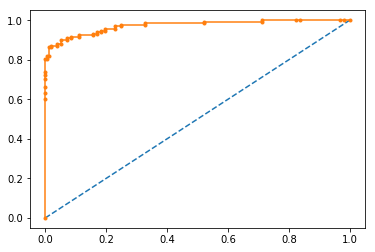

In [9]:
#Get AUC and create ROC
# predict probabilities
probs_rforest = rand_forest.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_rforest = probs_rforest[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y, probs_rforest)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
fpr_rforest, tpr_rforest, thresholds_rforest = roc_curve(test_Y, probs_rforest)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest, tpr_rforest, marker='.')
# show the plot
plt.show()

In [18]:
# perform classification report of the random forest
class_names = ['Class_0', 'Class_1']
rforest_report = classification_report(test_Y, y_pred_rforest, target_names=class_names)
print(rforest_report)

              precision    recall  f1-score   support

     Class_0       0.89      0.99      0.93       153
     Class_1       0.98      0.85      0.91       131

   micro avg       0.93      0.93      0.93       284
   macro avg       0.94      0.92      0.92       284
weighted avg       0.93      0.93      0.93       284



In [19]:
#create confusion matrix
confusion_matrix(test_Y, y_pred_rforest)

array([[151,   2],
       [ 19, 112]], dtype=int64)

## Logistic Regression Model:

In [24]:
#initialize and train our model
LogReg = LogisticRegression(C=1e9, random_state=12)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg = LogReg.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs = cross_val_score(LogReg, X, Y, cv=5, scoring='accuracy')
print(LogReg_cvs)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs)))

Accuracy score for Logistic regression Model: 0.9330985915492958

Duration: 0:00:00.078130

[0.90526316 0.94210526 0.89473684 0.92553191 0.89893617]
Average cross validated score from our log regression model is: 0.9133146696528556


C:\Users\PV-R68G\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PV-R68G\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PV-R68G\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PV-R68G\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PV-R68G\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

AUC Score: 0.970


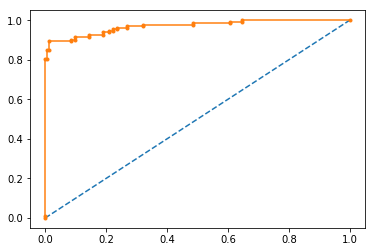

In [25]:
#Get AUC and create ROC
# predict probabilities
probs_LogReg = LogReg.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_LogReg = probs_LogReg[:, 1]
# calculate AUC
LogReg_auc = roc_auc_score(test_Y, probs_LogReg)
print('AUC Score: %.3f' % LogReg_auc)
# calculate roc curve
fpr_LogReg, tpr_LogReg, thresholds_LogReg = roc_curve(test_Y, probs_LogReg)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_LogReg, tpr_LogReg, marker='.')
# show the plot
plt.show()

In [26]:
# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
LogReg_report = classification_report(test_Y, y_pred_LogReg, target_names=class_names)
print(LogReg_report)

              precision    recall  f1-score   support

     Class_0       0.90      0.99      0.94       153
     Class_1       0.98      0.87      0.92       131

   micro avg       0.93      0.93      0.93       284
   macro avg       0.94      0.93      0.93       284
weighted avg       0.94      0.93      0.93       284



In [27]:
# create confusion matrix
confusion_matrix(test_Y, y_pred_LogReg)

array([[151,   2],
       [ 17, 114]], dtype=int64)

## Gradient Boosting

In [28]:
#Run gridsearchcv to find the best parameters for gradient boosting.
gboost_param_grid = {'n_estimators':[200,400,600], 'max_depth':[2,4,6], 'min_samples_leaf': [3, 5, 9], 
                     'learning_rate': [.05, .02, .01], 'subsample': [.7, .8, .9]}
gb_model = ensemble.GradientBoostingClassifier()

gb_grid = GridSearchCV(gb_model, gboost_param_grid, cv=5, verbose=3)
gb_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.9548872180451128, total=   0.4s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.924812030075188, total=   0.3s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.9545454545454546, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.9242424242424242, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.9242424242424242, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9548872180451128, total=   0.2s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.91729323

[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.8, score=0.9166666666666666, total=   0.8s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9624060150375939, total=   0.9s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9172932330827067, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.946969696969697, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.931818181

[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.924812030075188, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.946969696969697, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.9393939393939394, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.9166666666666666, total=   0.7s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9624060150

[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.8, score=0.9393939393939394, total=   0.5s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.8, score=0.9242424242424242, total=   0.4s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9624060150375939, total=   0.5s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9172932330827067, total=   0.5s
[CV] learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.94696969

[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9624060150375939, total=   1.1s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.924812030075188, total=   0.9s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9545454545454546, total=   0.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9393939393939394, total=   0.8s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.924242424

[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8, score=0.946969696969697, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8, score=0.9393939393939394, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8, score=0.9166666666666666, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9624060150375939, total=   0.5s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.924812030

[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=5, n_estimators=600, subsample=0.9, score=0.9090909090909091, total=   1.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9548872180451128, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.924812030075188, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9393939393939394, total=   0.4s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.939393939

[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.9323308270676691, total=   1.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.946969696969697, total=   1.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.9318181818181818, total=   1.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.9242424242424242, total=   1.0s
[CV] learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.962406015

[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=400, subsample=0.9, score=0.9242424242424242, total=   0.9s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=400, subsample=0.9, score=0.9318181818181818, total=   0.9s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9699248120300752, total=   1.1s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9398496240601504, total=   1.2s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.93939393

[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9624060150375939, total=   1.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.924812030075188, total=   1.2s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.946969696969697, total=   1.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9318181818181818, total=   0.9s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9090909090

[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9, score=0.9545454545454546, total=   0.6s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9, score=0.9393939393939394, total=   0.6s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9, score=0.9166666666666666, total=   0.6s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.9699248120300752, total=   1.0s
[CV] learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.05, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.93233082

[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.7, score=0.9242424242424242, total=   0.2s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9548872180451128, total=   0.2s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.924812030075188, total=   0.2s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.946969696969697, total=   0.2s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9090909090

[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.924812030075188, total=   0.8s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.946969696969697, total=   1.0s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9393939393939394, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9090909090909091, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.9548872180

[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.9393939393939394, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.7, score=0.9090909090909091, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9624060150375939, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9172932330827067, total=   0.7s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.94696969

[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9548872180451128, total=   0.5s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9172932330827067, total=   0.5s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.946969696969697, total=   0.5s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9318181818181818, total=   0.5s
[CV] learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.931818181

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.946969696969697, total=   0.9s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9318181818181818, total=   0.9s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9242424242424242, total=   0.9s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.9548872180451128, total=   0.9s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.924812030

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.8, score=0.9242424242424242, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9624060150375939, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9172932330827067, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9393939393939394, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.93181818

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9323308270676691, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9393939393939394, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9318181818181818, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9242424242424242, total=   0.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8, score=0.94736842

[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.9393939393939394, total=   1.3s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.8, score=0.9242424242424242, total=   1.3s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.9624060150375939, total=   1.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.924812030075188, total=   1.4s
[CV] learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.946969696

[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9624060150375939, total=   2.0s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9323308270676691, total=   1.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.946969696969697, total=   1.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9393939393939394, total=   1.9s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.924242424

[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9393939393939394, total=   1.3s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9318181818181818, total=   1.3s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9090909090909091, total=   1.3s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.9624060150375939, total=   1.4s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.92481203

[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=200, subsample=0.9, score=0.9318181818181818, total=   0.7s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.9624060150375939, total=   1.1s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.924812030075188, total=   1.1s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.9393939393939394, total=   1.4s
[CV] learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.924242424

[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9172932330827067, total=   0.3s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.946969696969697, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9015151515151515, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.8, score=0.9242424242424242, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=200, subsample=0.9, score=0.962406015

[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9242424242424242, total=   0.8s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=3, n_estimators=600, subsample=0.9, score=0.9242424242424242, total=   0.8s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.9699248120300752, total=   0.2s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.9172932330827067, total=   0.3s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.94696969

[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9548872180451128, total=   0.7s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9172932330827067, total=   0.7s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.946969696969697, total=   0.7s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.9242424242424242, total=   0.7s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=5, n_estimators=600, subsample=0.8, score=0.916666666

[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.946969696969697, total=   0.5s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9242424242424242, total=   0.6s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=400, subsample=0.9, score=0.9318181818181818, total=   0.6s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=600, subsample=0.7, score=0.9548872180451128, total=   0.7s
[CV] learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=2, min_samples_leaf=9, n_estimators=600, subsample=0.7, score=0.917293233

[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.7, score=0.9318181818181818, total=   0.9s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.9624060150375939, total=   0.9s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.924812030075188, total=   0.9s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.9393939393939394, total=   0.9s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=3, n_estimators=400, subsample=0.8, score=0.931818181

[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.924812030075188, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9318181818181818, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9166666666666666, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=200, subsample=0.9, score=0.9242424242424242, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=5, n_estimators=400, subsample=0.7, score=0.954887218

[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9166666666666666, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.7, score=0.9166666666666666, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8, score=0.9548872180451128, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8, score=0.9323308270676691, total=   0.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=200, subsample=0.8, score=0.93939393

[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.9548872180451128, total=   1.7s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.924812030075188, total=   1.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.9393939393939394, total=   1.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.9393939393939394, total=   1.4s
[CV] learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, min_samples_leaf=9, n_estimators=600, subsample=0.9, score=0.924242424

[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9393939393939394, total=   2.2s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9318181818181818, total=   2.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.7, score=0.9242424242424242, total=   2.0s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.8, score=0.9548872180451128, total=   2.2s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=3, n_estimators=600, subsample=0.8, score=0.92481203

[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.8, score=0.9242424242424242, total=   1.3s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.9699248120300752, total=   1.4s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.924812030075188, total=   1.4s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.9318181818181818, total=   1.4s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=5, n_estimators=400, subsample=0.9, score=0.924242424

[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.924812030075188, total=   1.1s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.946969696969697, total=   1.1s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.946969696969697, total=   1.1s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.7, score=0.9393939393939394, total=   1.1s
[CV] learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=6, min_samples_leaf=9, n_estimators=400, subsample=0.8, score=0.96240601503

[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed: 19.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 400, 600], 'max_depth': [2, 4, 6], 'min_samples_leaf': [3, 5, 9], 'learning_rate': [0.05, 0.02, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [29]:
print('Best parameters for decision tree:', gb_grid.best_params_)

Best parameters for decision tree: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 400, 'subsample': 0.7}


In [14]:
# Initialize and fit the model.
Grad_boost = ensemble.GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=5, 
                                                 n_estimators=400, subsample=0.7, random_state=14)

#set start time
start_time5 = datetime.datetime.now()

#fit and train the model
Grad_boost.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_Gboost = Grad_boost.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_Gboost)))

#calculate end time
end_time5 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time5 - start_time5))
print()

#get average accuracy score using cross validation
Grad_boost_cvs = cross_val_score(Grad_boost, X, Y, cv=5, scoring='accuracy')
print(Grad_boost_cvs)

print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_cvs)))

Accuracy score for Logistic regression Model: 0.9436619718309859

Duration: 0:00:01.464761

[0.94210526 0.94736842 0.9        0.96276596 0.89893617]
Average cross validated score from our Gradient Boosting model is: 0.93023516237402


AUC Score: 0.980


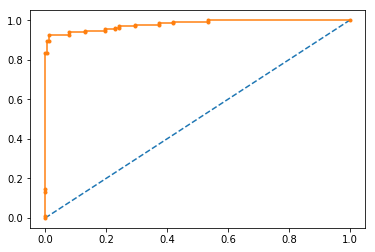

In [15]:
#Get AUC and create ROC
# predict probabilities
probs_Gboost = Grad_boost.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_Gboost = probs_Gboost[:, 1]
# calculate AUC
Gboost_auc = roc_auc_score(test_Y, probs_Gboost)
print('AUC Score: %.3f' % Gboost_auc)
# calculate roc curve
fpr_Gboost, tpr_Gboost, thresholds_Gboost = roc_curve(test_Y, probs_Gboost)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_Gboost, tpr_Gboost, marker='.')
# show the plot
plt.show()

In [16]:
# perform classification report of the Gradient Boosting model
class_names = ['Class_0', 'Class_1']
Gboost_report = classification_report(test_Y, y_pred_Gboost, target_names=class_names)
print(Gboost_report)

              precision    recall  f1-score   support

     Class_0       0.91      0.99      0.95       153
     Class_1       0.99      0.89      0.94       131

   micro avg       0.94      0.94      0.94       284
   macro avg       0.95      0.94      0.94       284
weighted avg       0.95      0.94      0.94       284



In [17]:
#confusion matrix
confusion_matrix(test_Y, y_pred_Gboost)

array([[152,   1],
       [ 15, 116]], dtype=int64)

## KNN Classifier

In [34]:
# perform grid search to find the optimal parameters for our KNN model.
KNN = KNeighborsClassifier()
param_grid = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN, param_grid, cv=5, verbose=3)
KNN_grid.fit(train_X, train_Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.5864661654135338, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6015037593984962, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6287878787878788, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.5303030303030303, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.7121212121212122, total=   0.0s
[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.6240601503759399, total=   0.0s
[CV] n_neighbors=5, weights=distance ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] n_neighbors=5, weights=distance .................................
[CV]  n_neighbors=5, weights=distance, score=0.6818181818181818, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV]  n_neighbors=10, weights=uniform, score=0.5639097744360902, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV]  n_neighbors=10, weights=uniform, score=0.5639097744360902, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV]  n_neighbors=10, weights=uniform, score=0.5833333333333334, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] ....... n_neighbors=10, weights=uniform, score=0.5, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV]  n_neighbors=10, weights=uniform, score=0.6666666666666666, total=   0.0s
[CV] n_neighbors=10, weights=distance ................................
[CV]  n_neighbors=10, weights=distan

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [35]:
print('Best parameters for data:', KNN_grid.best_params_)

Best parameters for data: {'n_neighbors': 5, 'weights': 'distance'}


In [20]:
#initialize and train our model using the training set
KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')

#set start time
start_time6 = datetime.datetime.now()

#fit and train the model
KNN.fit(train_X,train_Y)

#Make predictions using test_X, and store results in new variable
y_pred_KNN = KNN.predict(test_X)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y, y_pred_KNN)))

#calculate end time
end_time6 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time6 - start_time6))
print()


KNN_cvs = cross_val_score(KNN, X, Y, cv=5, scoring='accuracy')
print(KNN_cvs)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs)))


Accuracy score for KNN Model: 0.6373239436619719

Duration: 0:00:00.011007

[0.36842105 0.36842105 0.35789474 0.37765957 0.34574468]
Average cross validated score from our KNN model is: 0.3636282194848824


AUC Score: 0.666


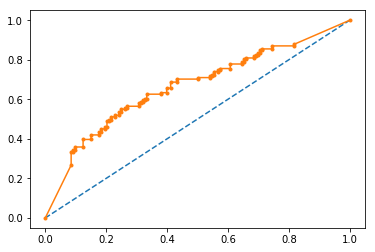

In [21]:
#Get AUC and create ROC
# predict probabilities
probs_KNN = KNN.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_KNN = probs_KNN[:, 1]
# calculate AUC
KNN_auc = roc_auc_score(test_Y, probs_KNN)
print('AUC Score: %.3f' % KNN_auc)
# calculate roc curve
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(test_Y, probs_KNN)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_KNN, tpr_KNN, marker='.')
# show the plot
plt.show()

In [22]:
# perform classification report of the KNN model
class_names = ['Class_0', 'Class_1']
KNN_report = classification_report(test_Y, y_pred_KNN, target_names=class_names)
print(Gboost_report)

              precision    recall  f1-score   support

     Class_0       0.91      0.99      0.95       153
     Class_1       0.99      0.89      0.94       131

   micro avg       0.94      0.94      0.94       284
   macro avg       0.95      0.94      0.94       284
weighted avg       0.95      0.94      0.94       284



In [23]:
# confusion Matrix
confusion_matrix(test_Y, y_pred_KNN)

array([[99, 54],
       [49, 82]], dtype=int64)

## SVM Model:

In [ ]:
from sklearn.svm import SVC

# Instantiate our model and fit the data.
svm = SVC(kernel = 'linear', probability=True, random_state=16)

#set start time
start_time7 = datetime.datetime.now()

#fit and train the model
svm.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_svm = svm.predict(test_X)

#get accuracy score from our model
print('Accuracy score for svm Model: ' + str(metrics.accuracy_score(test_Y, y_pred_svm)))

#calculate end time
end_time7 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time7 - start_time7))
print()

#get average accuracy score of svm model using cross validation
svm_cvs = cross_val_score(svm, X, Y, cv=5, scoring='accuracy')
print(svm_cvs)
print('Average accuracy score from our SVM model is: ' + str(np.mean(svm_cvs)))

Accuracy score for svm Model: 0.8873239436619719

Duration: 0:03:46.172456



In [ ]:
#Get AUC and create ROC
# predict probabilities
probs_svm = svm.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_svm = probs_svm[:, 1]
# calculate AUC
svm_auc = roc_auc_score(test_Y, probs_svm)
print('AUC Score: %.3f' % svm_auc)
# calculate roc curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_Y, probs_svm)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_svm, tpr_svm, marker='.')
# show the plot
plt.show()

In [ ]:
# perform classification report of the svm model
class_names = ['Class_0', 'Class_1']
svm_report = classification_report(test_Y, y_pred_svm, target_names=class_names)
print(svm_report)

In [ ]:
#create confusion matrix for svm
confusion_matrix(test_Y, y_pred_svm)

## Analysis

There are many things to consider when choosing the right model to predict credit card fraud.  Not only do we have to create a model that balances bias and variance in our predictions, but specifically for credit card fraud we should focus on the model that maximizes sensitivity.  

Sensitivity, also called the true positive rate, is defined as: True positives/(True positives + False negatives).  Basically, sensitivity shows how good a classification model is at catching positives.  The false positive rate, on the other hand, tells us how often our classification model incorrectly predict positive.

For our purpose, which is to detect credit card fraud, it's wise to maximize the true positive rate from our model because it would be more beneficial to the business to effectively and frequently catch and label a fraud incident as fraud, even at the cost of having some non-fraud incidents labeled as fraud.  So our aim is to maximize the true positive rate while minimizing the false positive rate to a manageable point.  This would significantly reduce the risk for the credit card company.

The ROC curve and AUC are good tools that can help us compare the different models, and pick the one that would be most beneficial to the business.  Visually speaking, the ROC curve that starts at the bottom left of the plot, and hugs along the left side as it extends to the top right of the plot, is the ideal ROC curve.  This curve will have the highest AUC score and the model associated with this score will effectively help us reach our goal of maximizing the true positive rate, and minimize the false positive rate.

For my analysis, I looked at seven different classifiers to help me classify fraud from our dataset.  These seven models are: Naive Bayes, Decision Tree, Random Forest, Logistic Regression, Gradient boost, KNearestNeighbor, and Support Vector Machines.

Naive Bayes was the first model I processed.  Given that our classifier was only dealing with a binary output, Naive Bayes was attractive because of its simplicity.  It was quick to process, but it did not have the highest average cross validated accuracy score nor the highest AUC score.  Its accuracy score was 90% and its AUC score was 94.5%.

The random forest model was alittle better.  I build an optimum random forest of 20 trees with a max depth of 6.  It had an average cross validated accuracy score of 93% and an AUC score of 97.3%.  It took alittle longer to process, but the extra time was a miniscule tenth of a second.

The Logistic Regression model gave an average cross validated score of 91.3%, and an AUC score of 97%.  

The Support Vector Machine took the longest to process.  Considering the length of our original dataset, and the simple binary nature of our class (dependent) variable, I ruled this model out.

The model that performed the worst was KNearestNeighbor.  Our model considered 5 neighbors (k value).  It had an averge cross validated score of 36%, and an AUC score of 67%.  This model was ruled out.

The best model to predict was the Gradient Boost model.  It had an average cross validated score of 93%, and an AUC score of 98%.  Performance wise, it was 1.2 seconds slower than the random forest model, but its high capability in accurately separating our two classes was well worth it.  Thus I would recommend the Gradient Boost model for this situation and this dataset.